# HinSAGE end-to-end

2 embedding layers + 1 node attribute inference layer, trained end to end to minimize cost function

In [272]:
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGENodeGenerator
from stellargraph.layer import HinSAGE, Dense
from stellargraph.ensemble import Ensemble, BaggingEnsemble
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append("../")
import utils
v_data, e_data, v_sets, e_sets, core_targets, ext_targets, core_testing = utils.load_for_jupyter()

Dataset already downloaded. Loading it from file system
LOADING DATA: 1.04 s
PREPROCESSING: 0.95 s


In [3]:
v_sets['Account']

,Revenue Size Flag,CoreCaseGraphID,ExtendedCaseGraphID,testingFlag,source_degree,target_degree
node_id,,,,,,
1502000,4,0.0,0.0,-1.0,2.0,7.0
1502001,1,0.0,0.0,-1.0,3.0,5.0
1502002,1,2492.0,0.0,0.0,5.0,6.0
1502003,4,0.0,0.0,-1.0,5.0,11.0
1502004,1,0.0,0.0,-1.0,3.0,3.0
...,...,...,...,...,...,...
15020149208,1,0.0,0.0,-1.0,0.0,1.0
15020149211,4,0.0,0.0,-1.0,0.0,1.0
15020151147,2,0.0,0.0,-1.0,0.0,1.0


In [4]:
# Sort based on testingFlag
for i in v_sets:
    v_sets[i] = v_sets[i].sort_values('testingFlag')
    print(i,":")
    print(v_sets[i].testingFlag.value_counts())
    v_sets[i] = v_sets[i].drop('testingFlag', axis=1)

Account :
-1.0    126863
 0.0     13769
 1.0      1244
Name: testingFlag, dtype: int64
Address :
-1.0    28432
 0.0     1568
Name: testingFlag, dtype: int64
Customer :
-1.0    42127
 0.0    13650
 1.0      449
Name: testingFlag, dtype: int64
Derived Entity :
-1.0    27286
 0.0     3925
 1.0       63
Name: testingFlag, dtype: int64
External Entity :
-1.0    55207
 0.0     4757
 1.0       36
Name: testingFlag, dtype: int64


In [5]:
# Removing ExtendedCaseID:

for i in v_sets:
    v_sets[i] = v_sets[i].drop('ExtendedCaseGraphID', axis=1)

In [6]:
# load dataset

G = sg.StellarDiGraph(v_sets, e_sets)

In [7]:
# split training + cv datasets

train_cv_set = v_sets['Account'][126863:126863+13769]

# these are the training+cv indexes
node_ids = train_cv_set.index.values.tolist()

# these are the training+cv Extended case ID
v_data.ExtendedCaseGraphID = v_data.ExtendedCaseGraphID.fillna(0)
ext_targets_2 = v_data.loc[[int(node_id) for node_id in node_ids]].ExtendedCaseGraphID

train_set = train_cv_set[:10000]
train_labels = ext_targets_2.values[:10000]

cv_set = train_cv_set[-3769:]
cv_labels = ext_targets_2.values[-3769:]

In [156]:
# test set

test_set = v_sets['Account'][-1244:]

In [130]:
# one-hot encoding of labels: required for tensorflow keras

target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_labels)
cv_targets = target_encoding.transform(cv_labels)

In [270]:
batch_size = 300
epochs = 30
num_samples = [8, 4]
dropout = 0.5
hinsage_layer_sizes = [32, 32]

In [274]:
# Ensemble parameters

use_bagging = True
n_estimators = 5
n_predictions = 10

In [275]:
# 2 hinsage model (hinsage layers)

generator = HinSAGENodeGenerator(
    G, 
    batch_size, 
    num_samples,
    head_node_type="Account"
)

train_gen = generator.flow(train_set.index, train_targets, shuffle=True)
cv_gen = generator.flow(cv_set.index, cv_targets)

In [276]:
hinsage = HinSAGE(
    layer_sizes=hinsage_layer_sizes,
    activations=['relu', 'relu'],
    generator=generator, 
    bias=True,
    normalize="l2",
    dropout=dropout
)

In [277]:
# Expose input and output sockets of hinsage:

x_inp, x_out = hinsage.in_out_tensors()

In [278]:
# Final estimator layer (node attribute inference)

n_classes = len(np.unique(train_labels))
predictions = Dense(units=n_classes, activation="softmax")(x_out)

In [279]:
# Create the Keras model, and compile it by specifying the optimizer, loss function to optimise, 
# and metrics for diagnostics:

import tensorflow.keras.backend as K

model = Model(inputs=x_inp, outputs=predictions)

model = BaggingEnsemble(model, n_estimators=n_estimators, n_predictions=n_predictions)

model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=['acc'],
)

In [280]:
# Define class weight array for reducing imbalance

from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# Create a dictionary that maps the one-hot encodings of the classes to the class weights

#class_weights_dict = dict({l: class_weights[i] for i, l in enumerate(np.unique(train_labels))})

class_weights_dict = dict(enumerate(class_weights))

In [281]:
#model.summary()

In [284]:
# Specify the number of workers to use for model training
num_workers = 8

In [295]:
# training step

if use_bagging:
    history = model.fit(
          generator=generator,
          train_data=train_set.index,
          train_targets=train_targets,
          epochs=epochs,
          validation_data=cv_gen,
          verbose=1,
          shuffle=False,
          bag_size=None,
          use_multiprocessing=False,
          workers=num_workers,
          class_weight=class_weights_dict,
          #use_early_stopping=True,  # Enable early stopping
          #early_stopping_monitor="val_acc",
        )

Epoch 1/30
34/34 [==============================] - 7s 219ms/step - loss: 7.5951 - acc: 0.0417 - val_loss: 6.9498 - val_acc: 0.1868
Epoch 2/30
34/34 [==============================] - 7s 209ms/step - loss: 7.4008 - acc: 0.1093 - val_loss: 6.8125 - val_acc: 0.22024s - loss: 7
Epoch 3/30
34/34 [==============================] - 6s 186ms/step - loss: 7.2268 - acc: 0.1439 - val_loss: 6.7123 - val_acc: 0.2221
Epoch 4/30
34/34 [==============================] - 7s 219ms/step - loss: 7.0808 - acc: 0.1455 - val_loss: 6.6415 - val_acc: 0.2186
Epoch 5/30
34/34 [==============================] - 8s 233ms/step - loss: 6.9620 - acc: 0.1385 - val_loss: 6.6334 - val_acc: 0.2011
Epoch 6/30
34/34 [==============================] - 7s 216ms/step - loss: 6.8549 - acc: 0.1312 - val_loss: 6.6401 - val_acc: 0.1889
Epoch 7/30
34/34 [==============================] - 8s 231ms/step - loss: 6.7663 - acc: 0.1268 - val_loss: 6.6486 - val_acc: 0.1783
Epoch 8/30
34/34 [==============================] - 8s 248ms/ste

34/34 [==============================] - 8s 224ms/step - loss: 5.9383 - acc: 0.0107 - val_loss: 7.3542 - val_acc: 2.6532e-04
Epoch 1/30
34/34 [==============================] - 7s 218ms/step - loss: 7.6872 - acc: 0.0250 - val_loss: 6.6977 - val_acc: 0.1698
Epoch 2/30
34/34 [==============================] - 7s 217ms/step - loss: 7.1019 - acc: 0.0965 - val_loss: 6.6863 - val_acc: 0.1358s - loss: 7.0345 - acc: 0. - ETA: 1s - loss: 6.9652 - acc: 0
Epoch 3/30
34/34 [==============================] - 7s 196ms/step - loss: 6.8250 - acc: 0.0803 - val_loss: 6.7282 - val_acc: 0.1024: 3s - loss: 6.
Epoch 4/30
34/34 [==============================] - 8s 223ms/step - loss: 6.6364 - acc: 0.0133 - val_loss: 6.8044 - val_acc: 0.0000e+00
Epoch 5/30
34/34 [==============================] - 8s 233ms/step - loss: 6.5260 - acc: 0.0057 - val_loss: 6.8799 - val_acc: 0.0000e+00
Epoch 6/30
34/34 [==============================] - 7s 218ms/step - loss: 6.4240 - acc: 0.0058 - val_loss: 6.9101 - val_acc: 0.0000e

34/34 [==============================] - 7s 207ms/step - loss: 6.0804 - acc: 0.0106 - val_loss: 7.4038 - val_acc: 5.3064e-04
Epoch 28/30
34/34 [==============================] - 7s 203ms/step - loss: 6.0417 - acc: 0.0101 - val_loss: 7.4082 - val_acc: 2.6532e-04
Epoch 29/30
34/34 [==============================] - 7s 204ms/step - loss: 6.0474 - acc: 0.0118 - val_loss: 7.4126 - val_acc: 2.6532e-04
Epoch 30/30
34/34 [==============================] - 6s 188ms/step - loss: 6.0383 - acc: 0.0111 - val_loss: 7.4661 - val_acc: 2.6532e-04
Epoch 1/30
34/34 [==============================] - 7s 203ms/step - loss: 7.7350 - acc: 0.0393 - val_loss: 6.6959 - val_acc: 0.1419
Epoch 2/30
34/34 [==============================] - 7s 205ms/step - loss: 7.1773 - acc: 0.0836 - val_loss: 6.6854 - val_acc: 0.1364
Epoch 3/30
34/34 [==============================] - 7s 207ms/step - loss: 6.8992 - acc: 0.0542 - val_loss: 6.7322 - val_acc: 0.0013
Epoch 4/30
34/34 [==============================] - 7s 208ms/step - 

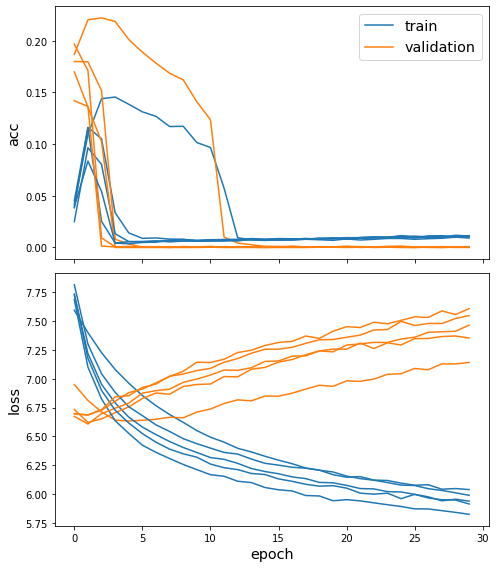

In [296]:
sg.utils.plot_history(history)

In [297]:
# make predictions

test_gen = generator.flow(test_set.index)
test_pred = model.predict(test_gen)

In [298]:
node_predictions = target_encoding.inverse_transform(test_pred.squeeze())

In [299]:
node_predictions.shape

(5, 1244, 2219)

In [304]:
df = pd.DataFrame(node_predictions[0]).rename(columns={0: 'ExtendedCaseGraphID'})
df['NodeID'] = test_set.index.values
df = df.set_index('NodeID')
#df = df.rename_axis('NodeID')
df

,ExtendedCaseGraphID,1,2,3,4,5,6,7,8,9,...,2209,2210,2211,2212,2213,2214,2215,2216,2217,2218
NodeID,,,,,,,,,,,,,,,,,,,,,
15020031251,0.0,1.0,1.0,1.0,19.0,19.0,19.0,19.0,1.0,19.0,...,1.0,1.0,1.0,1.0,19.0,1.0,19.0,1.0,1.0,19.0
15020044134,5.0,5.0,5.0,1.0,0.0,10.0,1.0,10.0,10.0,0.0,...,10.0,5.0,1.0,1.0,0.0,10.0,1.0,5.0,5.0,10.0
15020116575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15020031934,5.0,17.0,3.0,13.0,9.0,3.0,3.0,12.0,17.0,1.0,...,17.0,17.0,5.0,17.0,1.0,17.0,1.0,3.0,3.0,5.0
15020051188,5.0,17.0,5.0,9.0,13.0,5.0,9.0,5.0,5.0,5.0,...,5.0,5.0,17.0,17.0,5.0,5.0,9.0,5.0,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15020070563,17.0,13.0,12.0,12.0,13.0,13.0,13.0,13.0,3.0,13.0,...,13.0,3.0,3.0,3.0,5.0,19.0,3.0,12.0,12.0,5.0
1502002233,1.0,10.0,10.0,10.0,5.0,1.0,10.0,1.0,1.0,19.0,...,1.0,10.0,10.0,10.0,13.0,1.0,0.0,10.0,10.0,1.0
15020052758,12.0,12.0,12.0,12.0,9.0,3.0,12.0,3.0,13.0,9.0,...,3.0,12.0,12.0,12.0,1.0,3.0,12.0,12.0,12.0,5.0
